In [47]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from mazegenfromc import generate_maze

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Tạo mê cung

In [48]:
def mazetensor(maze_np):
    maze_tensor = torch.from_numpy(maze_np).float()
    
    # Batch_size, Channels, Height, Width
    # Số lượng, số lớp, chiều cao, chiều rộng
    #  1 ảnh, 1 màu, cao 10, rộng 10
    maze_tensor = maze_tensor.unsqueeze(0).unsqueeze(0)
    
    return maze_tensor

Hàm lấy vị trí đích

In [49]:
def get_goal_position(maze):

    result = np.where(maze == 9)
    
    y = int(result[0][0])
    x = int(result[1][0])
    return (y, x)
    

Hàm lấy vị trí agent hiện tại

In [50]:
def get_current_position(maze):
    
    result = np.where(maze == 2)
    
    y = int(result[0][0])
    x = int(result[1][0])
    return (y, x)


Hàm lấy tầm nhìn

In [51]:
def get_9x9_view(maze_np, heatmap_np, agent_position):
    pad_size = 4
    
    # Padding
    padded_maze = np.pad(maze_np, pad_size, mode='constant', constant_values=1)
    padded_heat = np.pad(heatmap_np, pad_size, mode='constant', constant_values=99)
    
    y, x = agent_position[0] + pad_size, agent_position[1] + pad_size
    
    # Cắt vùng 9x9
    maze_cut = padded_maze[y-4:y+5, x-4:x+5]
    heat_cut = padded_heat[y-4:y+5, x-4:x+5]
    
    heat_norm = 1.0 / (1.0 + heat_cut)

    heat_norm[maze_cut == 1] = 0.0
    
    # Chồng thành Tensor [2, 9, 9]
    stack_map = torch.stack([
        torch.from_numpy(maze_cut).float(),
        torch.from_numpy(heat_norm).float()
    ], dim=0)
    
    # Thêm chiều [1, 2, 9, 9]
    return stack_map.unsqueeze(0).to(device)

Hàm lấy vector chỉ hướng đích

In [52]:
def get_goal_vector(agent_position, goal_position, maze_size):

    #agent_pos: (y, x)
    #goal_pos: (y, x)
    #maze_size: (H, W)

    H, W = maze_size
    
    # 1. Tính khoảng cách thô
    dy = goal_position[0] - agent_position[0]
    dx = goal_position[1] - agent_position[1]
    
    # 2. Chuẩn hóa về khoảng [-1, 1]
    dy_norm = dy / H
    dx_norm = dx / W
    
    return torch.tensor([dy_norm, dx_norm], dtype=torch.float32).to(device)

Hàm cập nhật ô đã đi

In [53]:
def update_visit_count(heatmap, agent_position):
    y, x = agent_position
    heatmap[y, x] += 1
    return heatmap

Tạo hàm ánh xạ số trong lớp quyết định và hướng đi của agent

In [54]:
def get_next_position(current_position, action):

    y, x = current_position
    
    action_map = {
        0: (-1, 0), # Lên
        1: (1, 0),  # Xuống
        2: (0, -1), # Trái
        3: (0, 1)   # Phải
    }
    
    dy, dx = action_map[action]
    next_y = y + dy
    next_x = x + dx
    
    return (next_y, next_x)

Tạo các lớp tích chập (convolution layer)

In [55]:
conv_layers = nn.Sequential(
    # Lớp 1: 9*9 -> 7*7
    nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3), 
    nn.ReLU(),

    # Lớp 2: 7*7 -> 5*5
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(),

    # Lớp 3: 5*5 -> 3*3
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(),

    # Lớp 4: 3*3 -> 1*1
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
    nn.ReLU()
)
conv_layers = conv_layers.to(device)

Tạo lớp quyết định

In [56]:
decision_layer = nn.Linear(66, 4)
decision_layer = decision_layer.to(device)

Tạo hàm dự đoán bước tiếp theo

In [57]:
def predict_move(maze_np, heatmap_np, conv_layers, decision_layer, goal_position):
    with torch.no_grad():
        current_position = get_current_position(maze_np)

        live_view = get_9x9_view(maze_np, heatmap_np, current_position)
        view_4d = conv_layers(live_view)
        view_flat = torch.flatten(view_4d, start_dim=1)  # [1, 64, 1, 1] -> [1, 64]
    
        goal_vec = get_goal_vector(current_position, goal_position, maze_np.shape).unsqueeze(0)  # [dy_norm, dx_norm] -> [[dy_norm, dx_norm]]
    
        final_input = torch.cat((view_flat, goal_vec), dim=1)
    
        action_logits = decision_layer(final_input)
        action = torch.argmax(action_logits, dim=1).item()
    
        next_position = get_next_position(current_position, action)
    
    return action, next_position

Tạo hàm bước đi và hệ quả

In [58]:
def move(action, maze_np, heatmap_np, goal_position):

    curr_position = get_current_position(maze_np)
    old_dist = abs(goal_position[0] - curr_position[0]) + abs(goal_position[1] - curr_position[1])
    
    next_position = get_next_position(curr_position, action)
    nexty, nextx = next_position
    
    reward = 0
    done = False
    
    if nexty < 0 or nexty >= maze_np.shape[0] or nextx < 0 or nextx >= maze_np.shape[1] or maze_np[nexty, nextx] == 1:
        return -1, False 
        
    if maze_np[nexty, nextx] == 9:
        return 250, True
    
    if heatmap_np[nexty, nextx] > 0:
        reward -= 0.02 * heatmap_np[nexty, nextx] 
    else:
        reward -= 0.01 
    
    # Cập nhật trạng thái 2 lớp mê cung
    maze_np[curr_position[0], curr_position[1]] = 0
    maze_np[nexty, nextx] = 2
    update_visit_count(heatmap_np, next_position)
    
    return reward, done

Chọn optimizer và cách tính loss

In [59]:
all_parameters = list(conv_layers.parameters()) + list(decision_layer.parameters())
optimizer = optim.Adam(all_parameters, lr=0.0001)

losscal = nn.SmoothL1Loss()

Tạo mạng target độc lập

In [60]:
target_conv = copy.deepcopy(conv_layers).to(device)
target_decision = copy.deepcopy(decision_layer).to(device)

for p in target_conv.parameters(): p.requires_grad = False
for p in target_decision.parameters(): p.requires_grad = False

def update_target_network():
    target_conv.load_state_dict(conv_layers.state_dict())
    target_decision.load_state_dict(decision_layer.state_dict())

Deep Q-learning

In [61]:
def capture_state(maze_np, heatmap_np, goal_position):

    curr_position = get_current_position(maze_np)
    view = get_9x9_view(maze_np, heatmap_np, curr_position)
    
    goal_vec = get_goal_vector(curr_position, goal_position, maze_np.shape).unsqueeze(0) # [2] -> [1, 2]
    
    return (view, goal_vec)

In [62]:
memory_buffer = []
limit_memory = 100000

def store_memory(state, action, reward, next_state, done):
    if len(memory_buffer) >= limit_memory:
        memory_buffer.pop(0)
    memory_buffer.append((state, action, reward, next_state, done))

'''
batch (List)
 ├── b_0 (Tuple)
 │    ├── [0] State: ([view_0], [goal_0])
 │    ├── [1] Action: 3
 │    ├── [2] Reward: -0.01
 │    ├── [3] Next State: ([n_view_0], [n_goal_0])
 │    └── [4] Done: False
 ├── b_1 (Tuple)
 │    ├── [0] State: ([view_1], [goal_1])
 │    ├── ...
 ├── ...
 └── b_31 (Tuple)
'''

def train_from_memory(batch_size=32, gamma=0.99):
    if len(memory_buffer) < batch_size:
        return 0
    
    batch = random.sample(memory_buffer, batch_size)
    
    total_loss = 0
    
    # Gộp 32 mảng 9x9 thành 1 khối [32, 2, 9, 9]
    views = torch.cat([b[0][0] for b in batch]).to(device)
    goal_vecs = torch.cat([b[0][1] for b in batch]).to(device)
    actions = torch.tensor([b[1] for b in batch], dtype=torch.long).to(device)
    rewards = torch.tensor([b[2] for b in batch], dtype=torch.float32).to(device)
    
    next_views = torch.cat([b[3][0] for b in batch]).to(device)
    next_goal_vecs = torch.cat([b[3][1] for b in batch]).to(device)
    dones = torch.tensor([b[4] for b in batch], dtype=torch.float32).to(device)
    
    # Q-VALUE HIỆN TẠI (Main network)
    v_out = conv_layers(views)
    v_flat = torch.flatten(v_out, 1)
    combined = torch.cat((v_flat, goal_vecs), dim=1)
    q_values_all = decision_layer(combined) # [32, 4]
    
    q_value = q_values_all.gather(1, actions.unsqueeze(1)).squeeze(1)

    # Q-TARGET
    with torch.no_grad():
        
        nv_out = target_conv(next_views)
        nv_flat = torch.flatten(nv_out, 1)
        n_combined = torch.cat((nv_flat, next_goal_vecs), dim=1)
        
        # Double DQN
        # Main net chọn hành động
        v_next_out = conv_layers(next_views)
        v_next_flat = torch.flatten(v_next_out, 1)
        next_combined_main = torch.cat((v_next_flat, next_goal_vecs), dim=1)
        next_actions_main = decision_layer(next_combined_main).argmax(dim=1, keepdim=True)
        
        # Target net đánh giá hành động
        q_next_target_all = target_decision(n_combined)
        max_next_q = q_next_target_all.gather(1, next_actions_main).squeeze(1)
        
        # Công thức Bellman: R + gamma * Q_next * (1 - done)
        q_target = rewards + gamma * max_next_q * (1 - dones)

    loss = losscal(q_value, q_target)
    
    # Gradient Descent
    optimizer.zero_grad() 
    loss.backward()

    torch.nn.utils.clip_grad_norm_(all_parameters, max_norm=1.0)

    optimizer.step()
    
    return loss.item()

Đóng gói các hàm

In [63]:
def move_and_store(maze_np, heatmap_np, goal_position, random_rate):

    state_before = capture_state(maze_np, heatmap_np, goal_position)
    
    # Cơ chế Epsilon-Greedy 
    if np.random.rand() < random_rate:
        action = np.random.randint(0, 4) # Chọn ngẫu nhiên 1 trong 4 hướng
    else:
        action, _ = predict_move(maze_np, heatmap_np, conv_layers, decision_layer, goal_position)
    
    reward, done = move(action, maze_np, heatmap_np, goal_position)

    state_after = capture_state(maze_np, heatmap_np, goal_position)
    
    #Lưu
    store_memory(state_before, action, reward, state_after, done)
    
    return reward, done

In [80]:
def save_checkpoint(filename="maze_ai_checkpoint.pth"):
    checkpoint = {
        'conv_state': conv_layers.state_dict(),       
        'decision_state': decision_layer.state_dict(), 
        'optimizer_state': optimizer.state_dict(),                                                         
    }
    torch.save(checkpoint, filename)
    print(f"Đã lưu tham số vào file {filename}")

def load_checkpoint(filename="maze_ai_size_21.pth"):
    checkpoint = torch.load(filename, map_location=device)
    if torch.cuda.is_available():
        checkpoint = torch.load(filename)
    else:
        checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    
    # Nạp trọng số vào các lớp
    conv_layers.load_state_dict(checkpoint['conv_state'])
    decision_layer.load_state_dict(checkpoint['decision_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    
    
    print(f"Đã tải thành công! Tiếp tục ...")

In [81]:
load_checkpoint()

Đã tải thành công! Tiếp tục ...


In [ ]:
#memory_buffer.clear()

In [ ]:
#save_checkpoint()

Đã lưu tham số vào file maze_ai_checkpoint.pth


In [ ]:
#Vòng lặp train
"""

# Start setting
current_size = 23
max_size = 35
num_episodes = 15000
max_steps = int(current_size * current_size * 4) # Max steps theo size
random_rate = 0.4
target_update_steps = 1000 # Thời gian đóng băng mạng Target 
total_steps = 0

# Winrate tracker
win_history = np.zeros(100) # Lưu 100 ván gần nhất
win_idx = 0
played_enough = False

print(f"Bắt đầu huấn luyện từ Size {current_size}x{current_size}...")

for ep in range(num_episodes):
    
    maze_np = generate_maze(current_size) 
    heatmap_np = np.zeros_like(maze_np, dtype=np.float32)
    goal_position = get_goal_position(maze_np)
    
    done = False
    step_count = 0
    total_reward = 0
    
    while not done and step_count < max_steps:
        # Sử dụng epsilon-greedy để di chuyển
        reward, done = move_and_store(maze_np, heatmap_np, goal_position, random_rate)
        
        # Train
        loss = train_from_memory(batch_size=64)
        
        total_reward += reward
        total_steps += 1
        
        # Cập nhật mạng Target
        if total_steps % target_update_steps == 0:
            update_target_network()

        step_count += 1
    
    # Cập nhật win tracker
    win_history[win_idx] = 1 if done else 0
    win_idx = (win_idx + 1) % 100 # Tự reset win_idx
    if win_idx == 0: played_enough = True

    # Log thông tin ván đấu
    status = "THÀNH CÔNG" if done else "THẤT BẠI"
    print(f"Ván {ep+1:4d} | {status} | Size: {current_size}x{current_size} | Bước: {step_count} | Điểm: {total_reward:.2f} | Loss: {loss:.4f} | Epsilon: {random_rate:.3f}")

    # Kiểm tra điều kiện upsize
    if played_enough:
        current_win_rate = np.mean(win_history) 
        
        if current_win_rate >= 0.90 and current_size < max_size:
            print(f"Winrate 100 ván gần nhất: {current_win_rate*100:.1f}%")
            
            # Lưu
            save_checkpoint(filename=f"maze_ai_size_{current_size}.pth", epsilon=random_rate)
            
            # Upsize
            current_size += 2
            print(f"Upsize: {current_size}x{current_size}")
            
            # Reset setting
            random_rate = 0.4
            win_history.fill(0)
            win_idx = 0
            played_enough = False
            memory_buffer.clear()
            max_steps = int(current_size * current_size * 4) # Cập nhật lại giới hạn bước
            print(f"Đã reset Epsilon và Memory. Max steps mới: {max_steps}\n")

    if played_enough and current_win_rate < 0.3 and random_rate < 0.2:
        print("Increase epsilon due to low winrate")
        random_rate = 0.3

    # Epsilon decay rate
    if random_rate > 0.05:
        random_rate *= 0.998 

"""

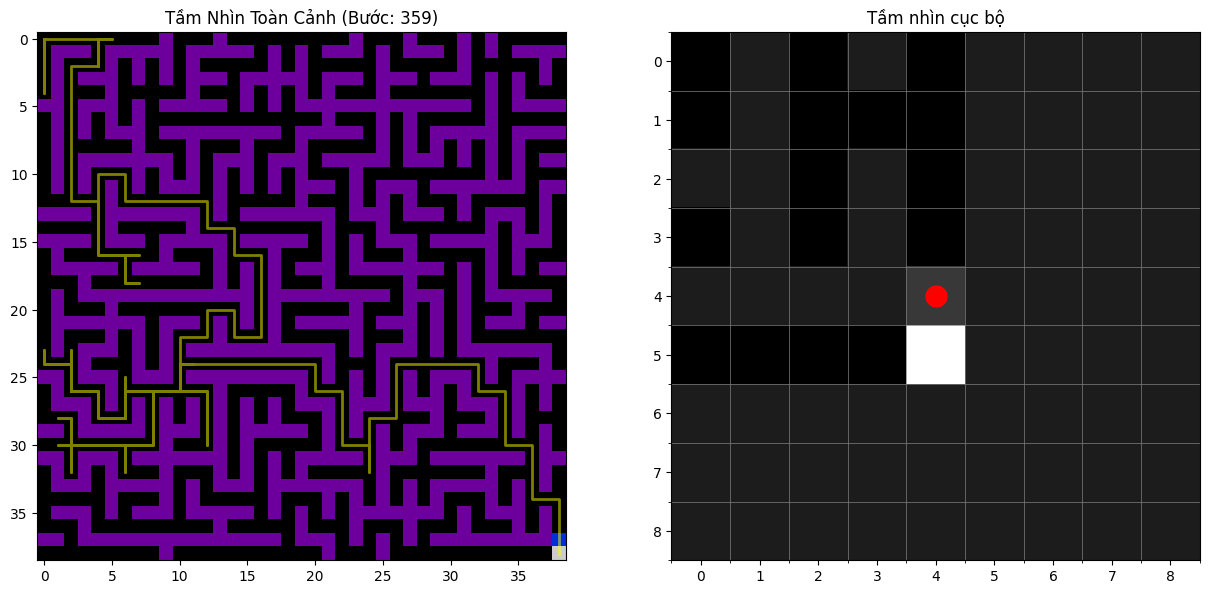

THÀNH CÔNG! AI đã về đích sau 360 bước.


In [ ]:
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt

def run_ai_showcase_split(complexity=18, sleep_time=0.01):
    # 1. Chế độ đánh giá
    conv_layers.eval()
    decision_layer.eval()
    
    # 2. Khởi tạo mê cung
    maze_np = generate_maze(complexity)
    heatmap_np = np.zeros_like(maze_np, dtype=np.float32)
    goal_position = get_goal_position(maze_np)
    current_pos = get_current_position(maze_np)
    
    path_history = [current_pos]
    steps = 0
    max_demo_steps = 1500
    
    # Thiết lập 2 bảng vẽ (Subplots)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    try:
        is_done = False
        while not is_done and steps < max_demo_steps:
            
            action, _ = predict_move(maze_np, heatmap_np, conv_layers, decision_layer, goal_position)
            
            # Lấy tầm nhìn 9x9 để hiển thị sang bảng bên phải
            # live_view_tensor có dạng [1, 2, 9, 9]
            live_view_tensor = get_9x9_view(maze_np, heatmap_np, current_pos)
            # Chuyển về numpy để vẽ (Lấy channel 0 là maze structure)
            ai_vision_img = live_view_tensor.squeeze(0)[0].cpu().numpy() 
            
            # Thực hiện bước đi
            reward, is_done = move(action, maze_np, heatmap_np, goal_position)
            
            # Cập nhật vị trí
            if is_done:
                current_pos = goal_position 
            else:
                current_pos = get_current_position(maze_np)
            
            path_history.append(current_pos)
            
            # TOÀN CẢNH 
            ax1.clear()
            ax1.imshow(maze_np, cmap='nipy_spectral')
            if len(path_history) > 1:
                hy, hx = zip(*path_history)
                ax1.plot(hx, hy, color='yellow', linewidth=2, alpha=0.5)
            ax1.set_title(f"Tầm Nhìn Toàn Cảnh (Bước: {steps})")
            
            # AI VISION (9x9) ---
            ax2.clear()
            # Hiển thị vùng 9x9 mà CNN đang xử lý
            ax2.imshow(ai_vision_img, cmap='binary_r') 
            # Vẽ một chấm đỏ ở giữa bảng 2 đại diện cho chính AI
            ax2.plot(4, 4, 'ro', markersize=15) 
            ax2.set_title(f"Tầm nhìn cục bộ")
            
            # Thêm các vạch lưới cho bảng 2 để nhìn rõ từng ô
            ax2.set_xticks(np.arange(-0.5, 9, 1), minor=True)
            ax2.set_yticks(np.arange(-0.5, 9, 1), minor=True)
            ax2.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

            clear_output(wait=True)
            display(fig)
            time.sleep(sleep_time)
            steps += 1
            
    except KeyboardInterrupt:
        print("Dừng biểu diễn.")
    finally:
        plt.close(fig)
        
    if is_done:
        print(f"THÀNH CÔNG! AI đã về đích sau {steps} bước.")
    else:
        print(f"THẤT BẠI! AI bị kẹt hoặc quá thời gian.")

# Chạy thử
run_ai_showcase_split(complexity=20, sleep_time=0.01)